# Time Series Analysis of Mouse Temperature and Activity Data

Understanding sex differences in physiological data is critical for biomedical research.

This notebook showcases how to:

- Identify and quantify sexual dimorphism in temperature regulation
- Detect multiple biological rhythms (circadian, ultradian, and estrous cycle effects)
- Apply advanced time series techniques to extract meaningful patterns from biological data
- Compare pattern similarities using Dynamic Time Warping


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix


/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/2109614720.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# load data
file_name = 'Mouse_Data_Student_Copy.xlsx'
dfs = pd.read_excel(file_name, sheet_name = None) # read all sheets in data

print("Sheet names: " , dfs.keys()) # view sheet names in data
dfs['Fem Act'].head()

Sheet names:  dict_keys(['Fem Temp', 'Fem Act', 'Male Temp', 'Male Act'])


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13
0,25.0,62.0,0.0,61.0,0.0,10.0,31.0,7.0,76.0,33.0,1.0,0.0,9.0
1,26.0,28.0,4.0,53.0,0.0,35.0,11.0,0.0,39.0,82.0,4.0,0.0,10.0
2,35.0,40.0,5.0,23.0,0.0,42.0,38.0,0.0,41.0,60.0,0.0,3.0,30.0
3,63.0,7.0,2.0,43.0,0.0,0.0,23.0,43.0,83.0,8.0,0.0,0.0,15.0
4,0.0,0.0,0.0,38.0,3.0,0.0,21.0,0.0,30.0,0.0,0.0,10.0,17.0


Preprocessing steps: 
1. Cap extreme temperature values: Lower bound at 35°C, upper bound at mean + 3 standard deviations
2. Cap extreme activity values: Upper bound at mean + 3 standard deviations
3. Add time indices for proper time series analysis

In [4]:
# clip based on paper
def cap_temp(df):
    for col in df.columns:
        mean = df[col].mean()
        std_dev = df[col].std()
        lower_bound = 35
        upper_bound = mean + 3 * std_dev
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

def cap_act(df):
    for col in df.columns:
        mean = df[col].mean()
        std_dev = df[col].std()
        upper_bound = mean + 3 * std_dev
        df[col] = df[col].clip(upper=upper_bound)
    return df

temperature_female = cap_temp(dfs['Fem Temp'])
temperature_male = cap_temp(dfs['Male Temp'])
activity_female = cap_act(dfs['Fem Act'])
activity_male = cap_act(dfs['Male Act'])


In [5]:
# add time column for resampling (done to compute at required frequency)
start_time = pd.to_datetime('2020-01-01 00:00:00')
time_index = pd.date_range(start_time, periods=len(temperature_female), freq='T')
temperature_female.index = time_index

for sheet in [temperature_female, temperature_male, activity_female, activity_male]:
    start_time = pd.to_datetime('2020-01-01 00:00:00') # random start date
    time_index = pd.date_range(start_time, periods=len(sheet), freq='T') # 1-min interval
    sheet.index = time_index
    # sheet.index.name = "Time"

/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/228015392.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range(start_time, periods=len(temperature_female), freq='T')
/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/228015392.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range(start_time, periods=len(sheet), freq='T') # 1-min interval


### EDA 

Let's check the following:
1. Hourly temperature averages between sexes
2. temperature variability differences
3. activity patterns between sexes

In [6]:
# Hourly averages
hourly_avg_f = temperature_female.resample('H').mean()
hourly_avg_m = temperature_male.resample('H').mean()

hourly_act_f_avg = activity_female.resample('H').mean()
hourly_act_m_avg = activity_male.resample('H').mean()


/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/1544879478.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_avg_f = temperature_female.resample('H').mean()
/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/1544879478.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_avg_m = temperature_male.resample('H').mean()
/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/1544879478.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_act_f_avg = activity_female.resample('H').mean()
/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/1544879478.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_act_m_avg = activity_male.resample('H').mean()


In [7]:
# mean across all mice per sex
hourly_avg_f["mean_all_mice"] = hourly_avg_f.mean(axis=1)
hourly_avg_m["mean_all_mice"] = hourly_avg_m.mean(axis=1)

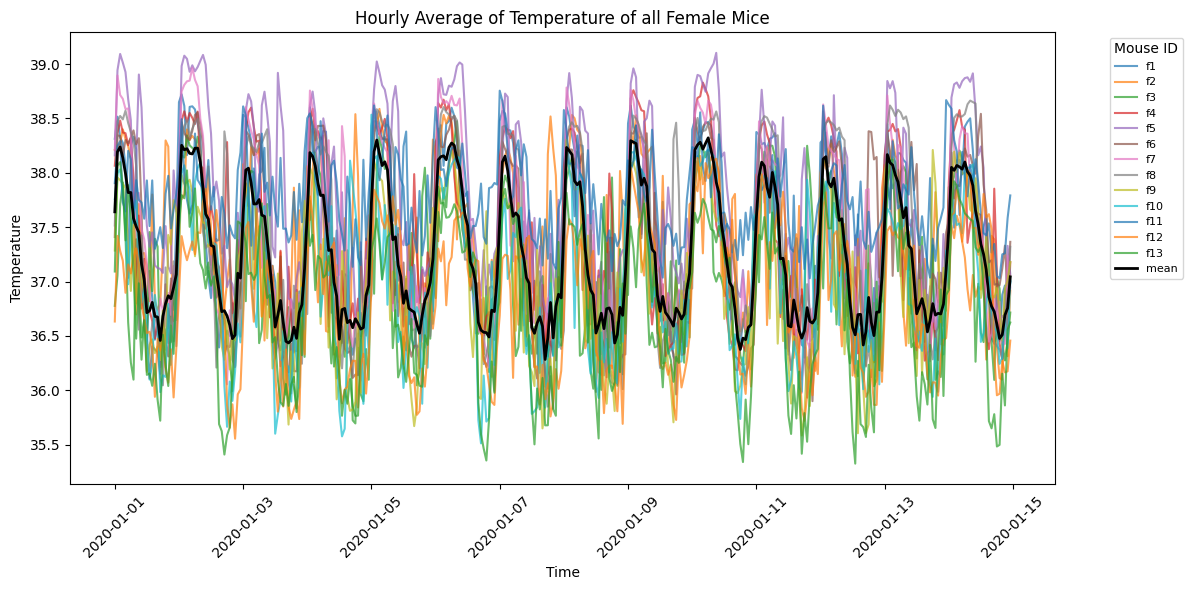

In [8]:
# Quick check: look at the data by plotting

# Plot each mouse's hourly data
plt.figure(figsize=(12, 6))

for col in hourly_avg_f.columns:
    if col != "mean_all_mice":
        plt.plot(hourly_avg_f.index, hourly_avg_f[col], label=col, alpha=0.7)  # alpha for transparency
    else:
        plt.plot(hourly_avg_f.index, hourly_avg_f[col], label="mean", color='black', linewidth=2)

plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Hourly Average of Temperature of all Female Mice")


plt.legend(title="Mouse ID", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.xticks(rotation=45)
# plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()




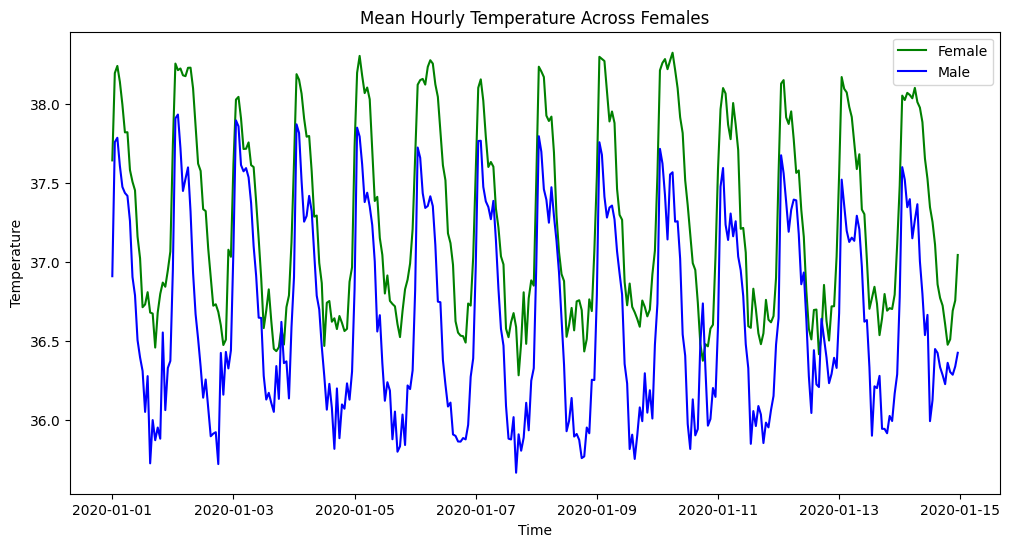

In [9]:
# compare male mean vs female mean
plt.figure(figsize=(12, 6))
plt.plot(hourly_avg_f.index, hourly_avg_f["mean_all_mice"], linestyle='-', color='green', label="Female")
plt.plot(hourly_avg_m.index, hourly_avg_m["mean_all_mice"], linestyle='-', color='blue', label="Male")

plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Mean Hourly Temperature Across Females")
plt.legend()
# plt.xticks(rotation=45)
# plt.grid()
plt.show()


The graph above shows that females generally have a higher CBT than males. Could this be because of the estrous cycle? 
Now let's also investigate the temperature variability across sexes.

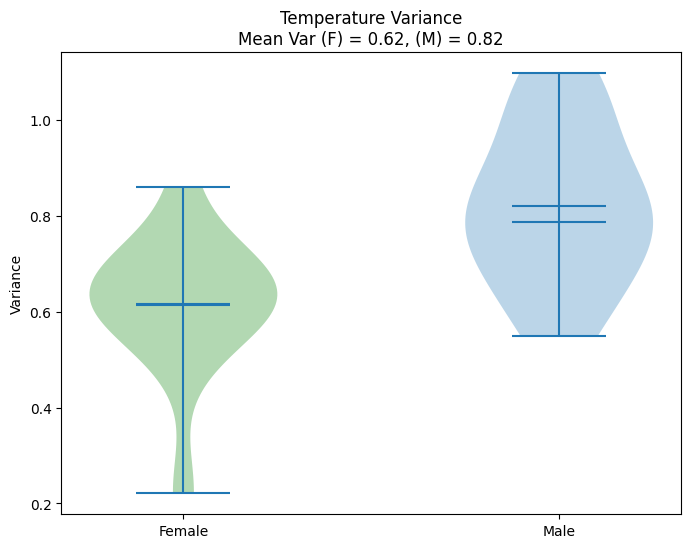

In [10]:
# Calculate temperature variance for each mouse
female_temp_var = temperature_female.var(axis=0)
male_temp_var = temperature_male.var(axis=0)

# Simple summary stats instead of Wilcoxon test
female_mean_var = np.mean(female_temp_var)
male_mean_var = np.mean(male_temp_var)

# Violin plot
plt.figure(figsize=(8, 6))
violin_data = plt.violinplot([female_temp_var, male_temp_var], showmeans=True, showmedians=True)

plt.xticks([1, 2], ['Female', 'Male'])
violin_data['bodies'][0].set_facecolor('green')

# Updated title with summary stats
plt.title(f'Temperature Variance\nMean Var (F) = {female_mean_var:.2f}, (M) = {male_mean_var:.2f}')
plt.ylabel('Variance')
plt.show()


/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/1258330648.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  f_hourly_temp_var = temperature_female.resample('H').var()
/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/1258330648.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  m_hourly_temp_var = temperature_male.resample('H').var()


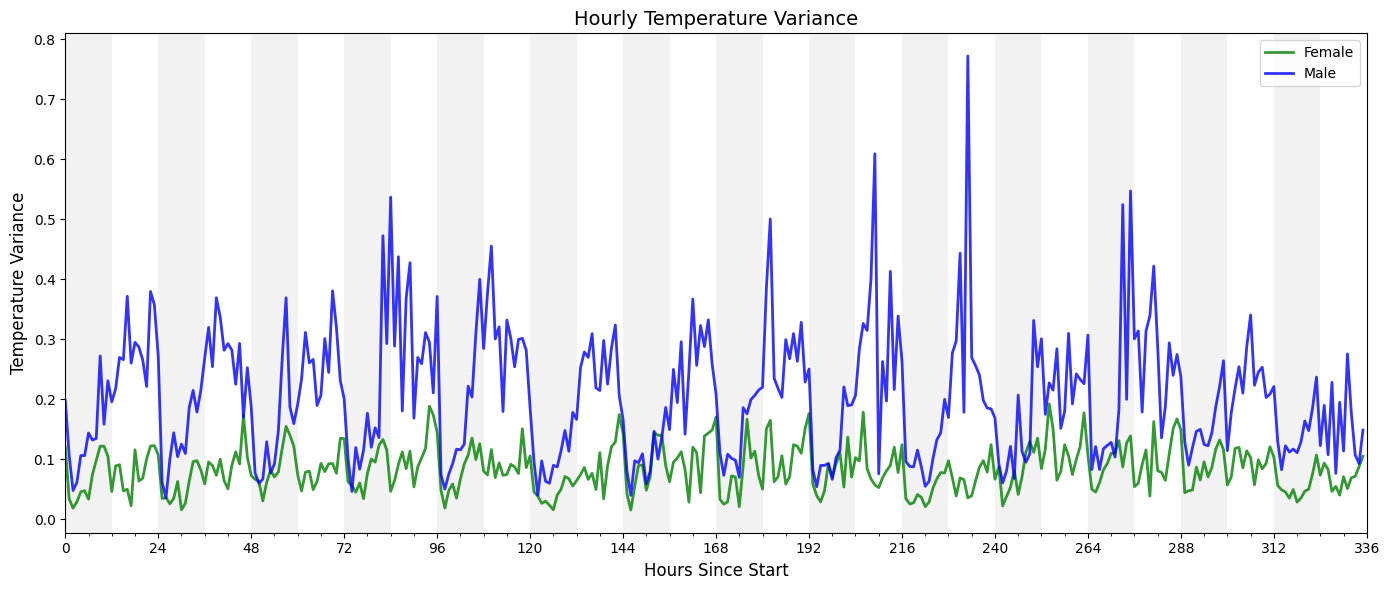

In [11]:
# a more granular view of the variance - hourly

f_hourly_temp_var = temperature_female.resample('H').var()
m_hourly_temp_var = temperature_male.resample('H').var()
mean_hourly_var_female = f_hourly_temp_var.mean(axis=1)
mean_hourly_var_male = m_hourly_temp_var.mean(axis=1)

# cnvert datetime index to hours (0–336)
hours_since_start = (mean_hourly_var_female.index - mean_hourly_var_female.index[0]).total_seconds() / 3600

# Plot
plt.figure(figsize=(14, 6))
plt.plot(hours_since_start, mean_hourly_var_female.values, label='Female', color='green', alpha=0.8, linewidth=2)
plt.plot(hours_since_start, mean_hourly_var_male.values, label='Male', color='blue', alpha=0.8, linewidth=2)

# Customize x-axis
plt.xticks(np.arange(0, 337, 24), labels=np.arange(0, 337, 24))
plt.xlim(0, 336)
plt.xlabel('Hours Since Start', fontsize=12)

# shaded dark periods (06:00–18:00 daily)
for day in range(14):  # 14 days = 336 hours
    plt.axvspan(day*24, day*24+12 , color='gray', alpha=0.1, linewidth=0, zorder=-1)


plt.title('Hourly Temperature Variance', fontsize=14)
plt.ylabel('Temperature Variance', fontsize=12)
plt.legend(fontsize=10)
# plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(6))  # Minor ticks every 6 hours

plt.tight_layout()
plt.show()

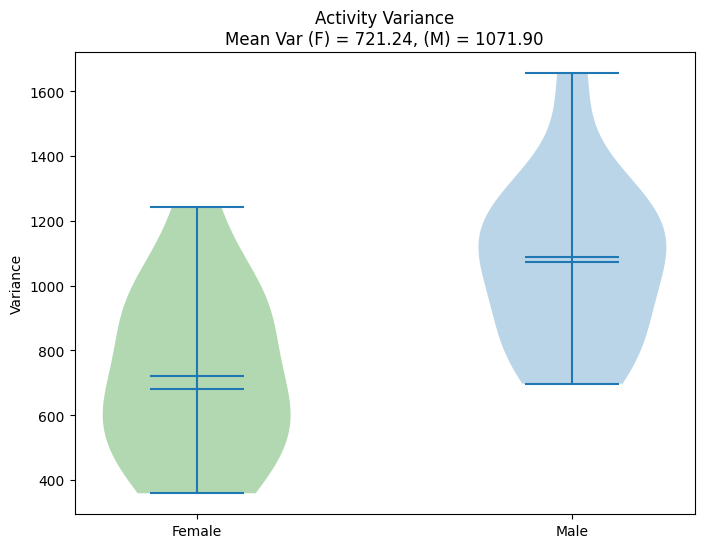

In [12]:
# activity variances

female_act_var = activity_female.var(axis=0)
male_act_var = activity_male.var(axis=0)

# Calculate mean variance for summary
female_mean_act_var = np.mean(female_act_var)
male_mean_act_var = np.mean(male_act_var)

# Violin plot
plt.figure(figsize=(8, 6))
violin_data = plt.violinplot([female_act_var, male_act_var], showmeans=True, showmedians=True)

plt.xticks([1, 2], ['Female', 'Male'])
violin_data['bodies'][0].set_facecolor('green')

# Updated title with summary stats
plt.title(f'Activity Variance\nMean Var (F) = {female_mean_act_var:.2f}, (M) = {male_mean_act_var:.2f}')
plt.ylabel('Variance')
plt.show()


/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/3841695116.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  f_hourly_temp_var = temperature_female.resample('H').var()
/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/3841695116.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  m_hourly_temp_var = temperature_male.resample('H').var()
/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/3841695116.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  f_hourly_act_var = activity_female.resample('H').var()
/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/3841695116.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  m_hourly_act_var = activity_male.resample('H').var()


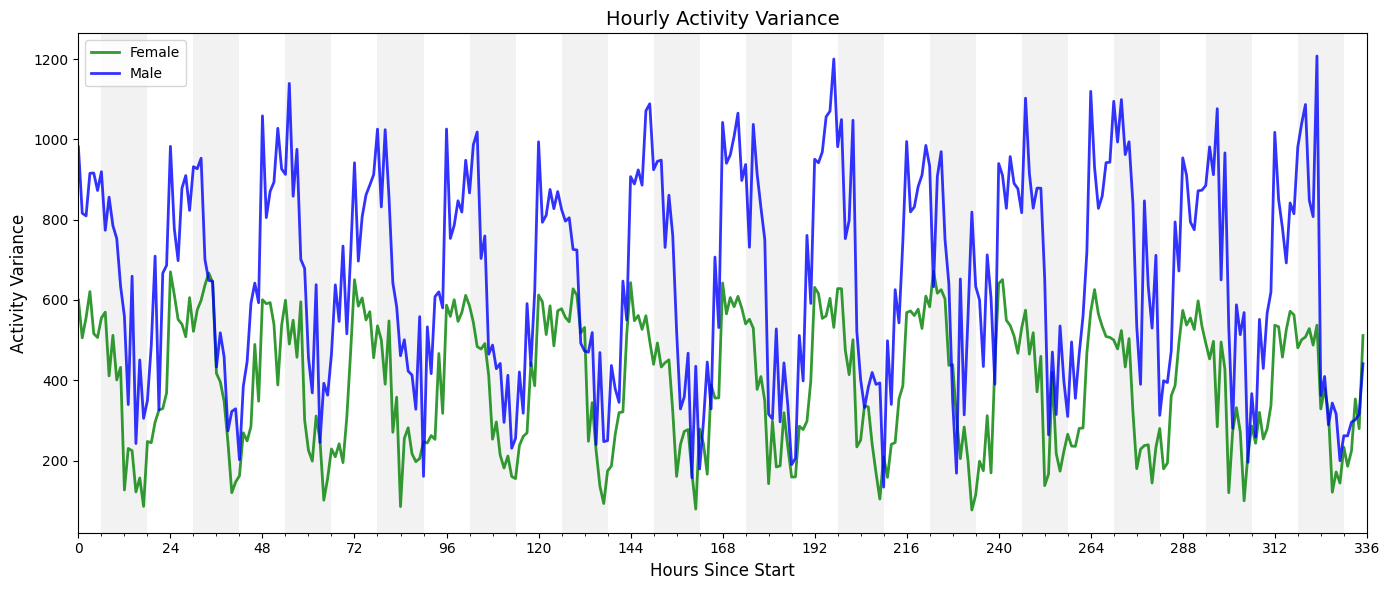

In [13]:
# Hourly variance (temperature)
f_hourly_temp_var = temperature_female.resample('H').var()
m_hourly_temp_var = temperature_male.resample('H').var()

# A more granular view of the variance - hourly
f_hourly_act_var = activity_female.resample('H').var()
m_hourly_act_var = activity_male.resample('H').var()

mean_hourly_var_female = f_hourly_act_var.mean(axis=1)
mean_hourly_var_male = m_hourly_act_var.mean(axis=1)

# Convert datetime index to hours (0–336)
hours_since_start = (mean_hourly_var_female.index - mean_hourly_var_female.index[0]).total_seconds() / 3600

# Plot
plt.figure(figsize=(14, 6))
plt.plot(hours_since_start, mean_hourly_var_female.values, label='Female', color='green', alpha=0.8, linewidth=2)
plt.plot(hours_since_start, mean_hourly_var_male.values, label='Male', color='blue', alpha=0.8, linewidth=2)

# Customize x-axis
plt.xticks(np.arange(0, 337, 24), labels=np.arange(0, 337, 24))
plt.xlim(0, 336)
plt.xlabel('Hours Since Start', fontsize=12)

# Shaded dark periods (06:00–18:00 daily)
for day in range(14):  # 14 days = 336 hours
    plt.axvspan(day * 24 + 6, day * 24 + 18, color='gray', alpha=0.1, linewidth=0, zorder=-1)

plt.title('Hourly Activity Variance', fontsize=14)
plt.ylabel('Activity Variance', fontsize=12)
plt.legend(fontsize=10)
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(6))  # Minor ticks every 6 hours

plt.tight_layout()
plt.show()


/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/1887513070.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_avg_act_f = activity_female.resample('H').mean().mean(axis=1)
/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/1887513070.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_avg_act_m = activity_male.resample('H').mean().mean(axis=1)


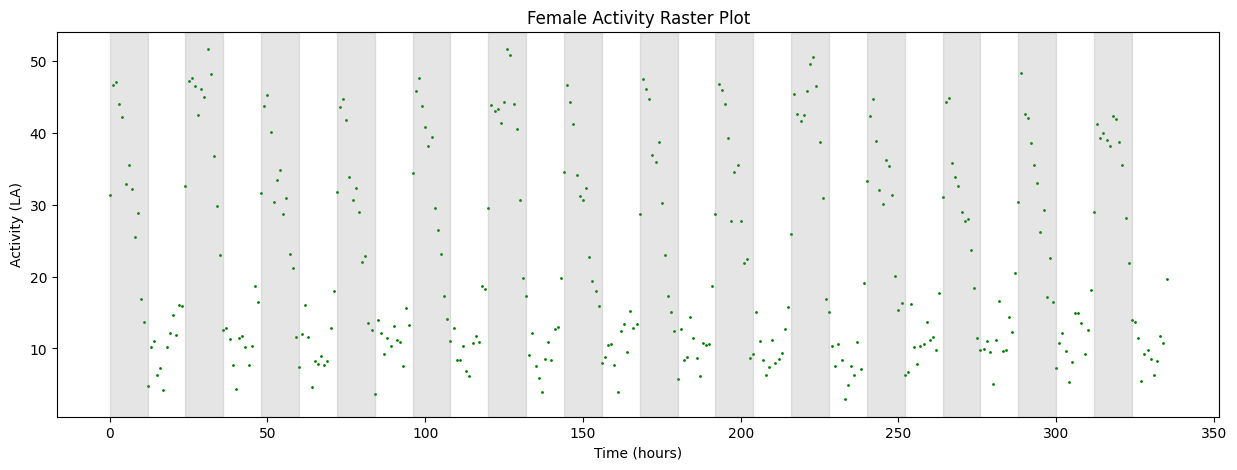

In [14]:
# Activity Raster plot
hourly_avg_act_f = activity_female.resample('H').mean().mean(axis=1)
hourly_avg_act_m = activity_male.resample('H').mean().mean(axis=1)

time = np.arange(0, 336)

# activity plots
plt.figure(figsize=(15, 5))
plt.scatter(time, hourly_avg_act_f, color='green', s=1)
plt.title('Female Activity Raster Plot')
plt.ylabel('Activity (LA)')
plt.xlabel('Time (hours)')


for day in range(14):
    plt.axvspan(24*day, 24*day+12, color='gray', alpha=0.2)

plt.show()

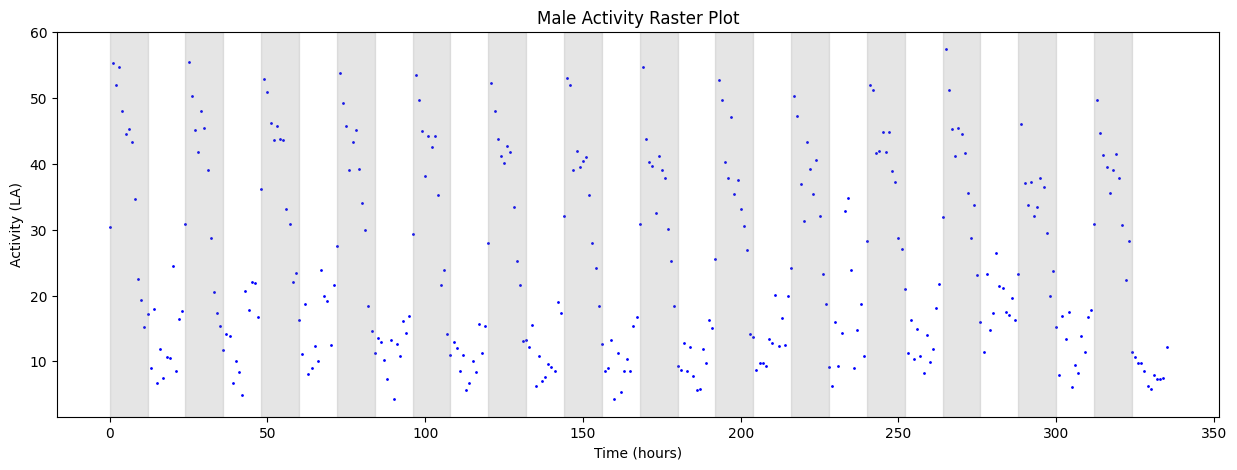

In [15]:
# Activty Raster plot - Male
time = np.arange(0, 336)

# activity plots
plt.figure(figsize=(15, 5))
plt.scatter(time, hourly_avg_act_m, color='blue', s=1)
plt.title('Male Activity Raster Plot')
plt.ylabel('Activity (LA)')
plt.xlabel('Time (hours)')


for day in range(14):
    plt.axvspan(24*day, 24*day+12, color='gray', alpha=0.2)

plt.show()

Mice are nocturnal!

### Estrous cycle analysis

In [16]:
estrus_days = [1, 5, 9] # estrus days are days 1, 5, and 9
                    
def add_day_num(df):
    start_date = df.index[0].date()
    df['day_number'] = [(ts.date() - start_date).days for ts in df.index]
    return df

# add day number col
temp_female = add_day_num(temperature_female)
act_female = add_day_num(activity_female)

temp_male = add_day_num(temperature_male)
act_male = add_day_num(activity_male)

<Axes: xlabel='day_number'>

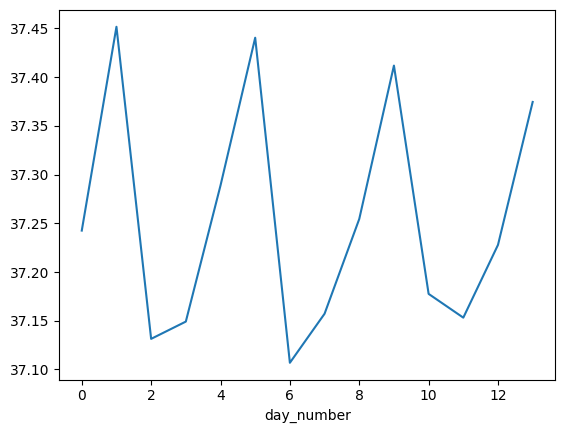

In [17]:
# quick avg daily temp check
temp_female.groupby('day_number').mean().mean(axis=1).plot()

It does look like days 1, 5, 9 have slightly higher than average daily body temperature. This is most likely because estrus has an extended period of higher body temperature (which would drive the average up).

In [18]:
# estrus splitter
def split_estrus_data(df, estrus_days):
   #  masks
   mask = np.array([day in estrus_days for day in df['day_number']])
   return df[mask], df[~mask]

In [19]:
# split temperature data
temp_f_estrus, temp_f_non_estrus = split_estrus_data(temperature_female, estrus_days)

# split activity data
act_f_estrus, act_f_non_estrus = split_estrus_data(activity_female, estrus_days)

In [20]:
def compute_hourly_variance(df):
    # get hourly variance for each mouse
    hourly_var = df.resample('H').var()
    # average across mice
    return hourly_var.mean(axis=1)


In [21]:
# hourly temperature variance
temp_estrus_var = compute_hourly_variance(temp_f_estrus)
temp_non_estrus_var = compute_hourly_variance(temp_f_non_estrus)

# hourly activity variance
act_estrus_var = compute_hourly_variance(act_f_estrus)
act_non_estrus_var = compute_hourly_variance(act_f_non_estrus)


/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/475439333.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_var = df.resample('H').var()
/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/475439333.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_var = df.resample('H').var()
/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/475439333.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_var = df.resample('H').var()
/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_69059/475439333.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_var = df.resample('H').var()


In [22]:
# compute daily ranges for each mouse =(max - min)
def compute_daily_ranges(df):
    daily_ranges = df.groupby('day_number').agg(lambda x: x.max() - x.min()).reset_index()
    return daily_ranges

In [23]:
# Create function to put data in long format for plotting
def prepare_plot_data(male_all, female_all, female_non_estrus):
    male_all_df = male_all.melt(id_vars='day_number', var_name='mouse', value_name='value').assign(gender='Male', condition='All days') # male all days
    female_all_df = female_all.melt(id_vars='day_number', var_name='mouse', value_name='value').assign(gender='Female', condition='All days') # female all days
    female_non_estrus_df = female_non_estrus.melt(id_vars='day_number', var_name='mouse', value_name='value').assign(gender='Female', condition='Without estrus') # female non-estrus
    male_non_estrus_df = male_all.melt(id_vars='day_number', var_name='mouse', value_name='value').assign(gender='Male', condition='Without estrus') # male non-estrus (same as all days)
    return pd.concat([male_all_df, female_all_df, female_non_estrus_df, male_non_estrus_df])

In [24]:
def create_plots(plot_df, title, y_label):
    """Generate side-by-side boxplots for All Days and Without Estrus using matplotlib."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    conditions = ['All days', 'Without estrus']
    for ax, condition, subtitle in zip(axes, conditions, ['All Days', 'Without Estrus Days']):
        data = plot_df[plot_df['condition'] == condition]
        
        female_vals = data[data['gender'] == 'Female']['value'].values
        male_vals = data[data['gender'] == 'Male']['value'].values

        ax.boxplot([female_vals, male_vals], labels=['Female', 'Male'], patch_artist=True,
                   boxprops=dict(facecolor='lightgreen'),
                   medianprops=dict(color='black'),
                   whiskerprops=dict(color='gray'),
                   capprops=dict(color='gray'))

        ax.set_title(subtitle)
        ax.set_xlabel('')
        if subtitle == 'All Days':
            ax.set_ylabel(y_label)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


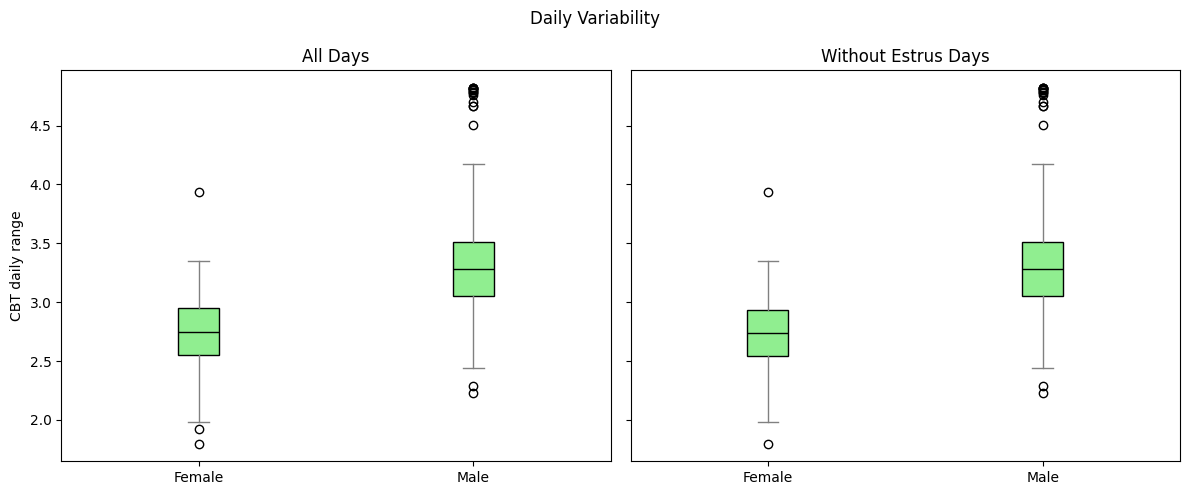

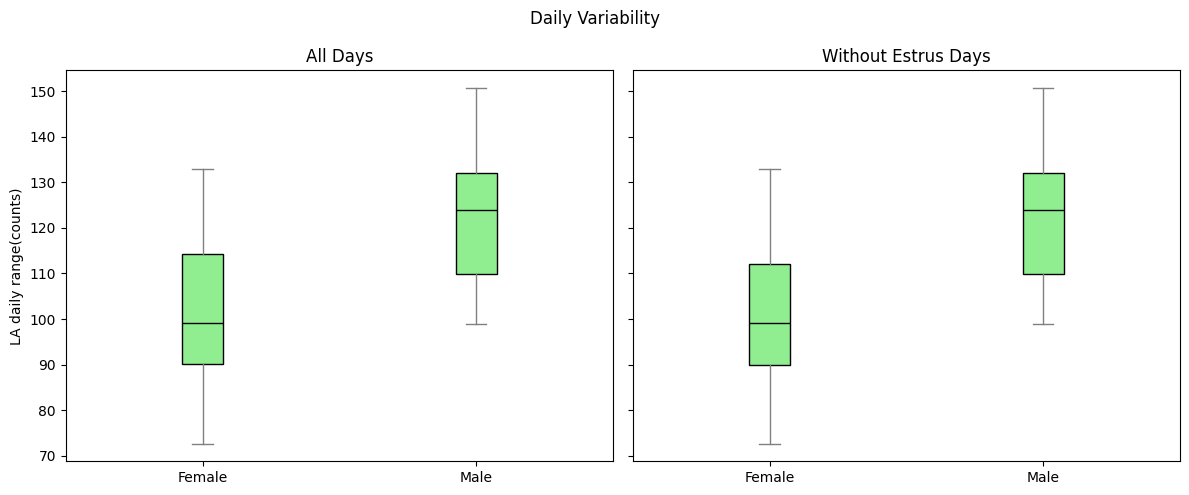

In [25]:
# daily temp ranges
temp_male_daily = compute_daily_ranges(temp_male)
temp_female_daily = compute_daily_ranges(temp_female)
temp_f_estrus, temp_f_non_estrus = split_estrus_data(temp_female_daily, estrus_days)

# daily activity ranges
act_male_daily = compute_daily_ranges(act_male)
act_female_daily = compute_daily_ranges(act_female)
act_f_estrus, act_f_non_estrus = split_estrus_data(act_female_daily, estrus_days)

# prepare data for plotting
temp_plot_df = prepare_plot_data(temp_male_daily, temp_female_daily, temp_f_non_estrus)
act_plot_df = prepare_plot_data(act_male_daily, act_female_daily, act_f_non_estrus)

# generate plots
create_plots(temp_plot_df, 'Daily Variability', 'CBT daily range')
create_plots(act_plot_df, 'Daily Variability', 'LA daily range(counts)')

It looks like the removal of estrus days (from the female data) has minimal effect on the ranges, suggesting that the sex difference is not primarily driven by the estrous cycle

### Rhythmic Pattern analysis using Wavelet Transforms

In [26]:
# Check data dimensions and time span
print(f"Data shape: {temperature_female.shape}")
print(f"Date range: {temperature_female.index[0]} to {temperature_female.index[-1]}")

Data shape: (20160, 14)
Date range: 2020-01-01 00:00:00 to 2020-01-14 23:59:00


In [27]:
# Constants
mouse_columns_f = [col for col in temperature_female.columns if col != 'day_number']
mouse_columns_m = [col for col in temperature_male.columns if col != 'day_number']
mins_per_day = 1440
days_per_cycle = 4


In [28]:
# Calculate median 4-day cycle for each mouse
def median_cycle(df, mouse_cols):
    unique_days = sorted(df['day_number'].unique())
    
    # create cycle definitions (4 day estrous cycle)
    # 0-based indexing. Ignore day 0 and day 13 to account for edge effects
    cycle_days = {
        0: [1, 5, 9],  
        1: [2, 6, 10],  
        2: [3, 7, 11], 
        3: [4, 8, 12]  
    }
    # Dictionary to store data for each position in the cycle
    cycle_position_data = {pos: [] for pos in range(4)}
    
    # For each mouse and each position in the cycle
    median_cycle_dict = {}
    
    for mouse in mouse_cols:
        mouse_cycle_data = []       # store data for this mouse
        for cycle_pos in range(4): # 4 positions in the cycle
            days_for_this_pos = cycle_days[cycle_pos]
            day_data_list = []
            for day_num in days_for_this_pos: # get data for each day in the cycle
                day_data = df[df['day_number'] == day_num][mouse].values
                day_data_list.append(day_data)
            avg_day_data = np.mean(day_data_list, axis=0) # average the data for this position across all corresponding days
            mouse_cycle_data.extend(avg_day_data) 
        median_cycle_dict[mouse] = mouse_cycle_data # complete 4-day cycle for this mouse
    
    minutes_in_cycle = mins_per_day * 4
    cycle_index = pd.timedelta_range(start='0 days', periods=minutes_in_cycle, freq='1min')
    median_cycles_df = pd.DataFrame(median_cycle_dict, index=cycle_index) # median cycle df for each mouse
    
    return median_cycles_df

In [29]:
median_cycles_female = median_cycle(temperature_female, mouse_columns_f)
pop_avg_female = median_cycles_female.mean(axis=1)

median_cycles_male = median_cycle(temperature_male, mouse_columns_m)
pop_avg_male = median_cycles_male.mean(axis=1)

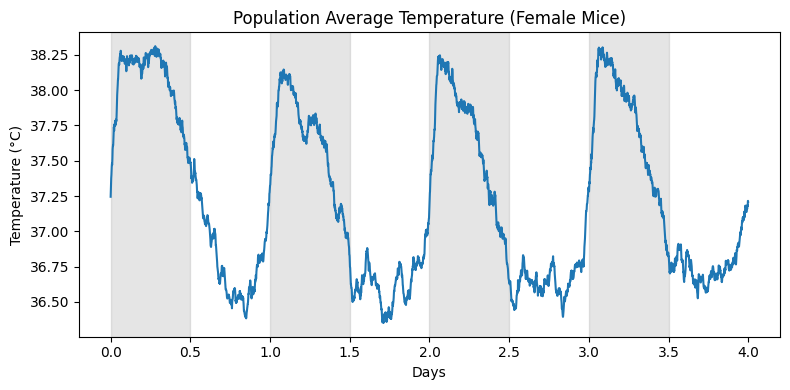

In [30]:
# Basic plot of population average
plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(pop_avg_female))/mins_per_day, pop_avg_female)
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.title('Population Average Temperature (Female Mice)')
# plt.grid(True)
plt.xticks(np.arange(0, 5, 0.5))

for day in range(4):
    plt.axvspan(day, day+.5, color='gray', alpha=0.2)
plt.tight_layout()
plt.show()

# print("Median 4-day cycle shape:", median_cycles_female.shape)
# print("Population average shape:", pop_avg_female.shape)




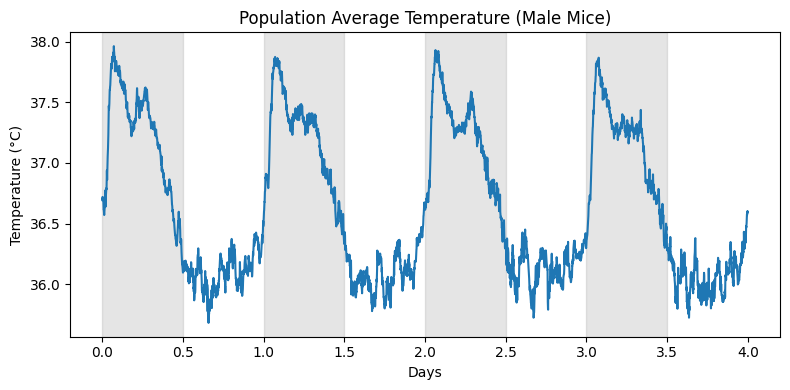

In [31]:
# male plot of population average
plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(pop_avg_male))/mins_per_day, pop_avg_male)
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.title('Population Average Temperature (Male Mice)')
# plt.grid(True)
plt.xticks(np.arange(0, 5, 0.5))

for day in range(4):
    plt.axvspan(day, day+.5, color='gray', alpha=0.2)
plt.tight_layout()
plt.show()

### Wavelet analysis
Wavelet transforms are particularly useful for analyzing time series data with cyclical patterns. Unlike Fourier transforms, wavelets can detect localized changes in periodicity and don't assume that the signal is stationary. We'll use the continuous wavelet transform (CWT) to identify different periodicities in our temperature data.

In [32]:
# First let's start with a random mouse
sample_mouse_f = temperature_female['f1']
sample_mouse_m = temperature_male['m1']

Data shape: (20160,)
Min value: 35.81, Max value: 39.02


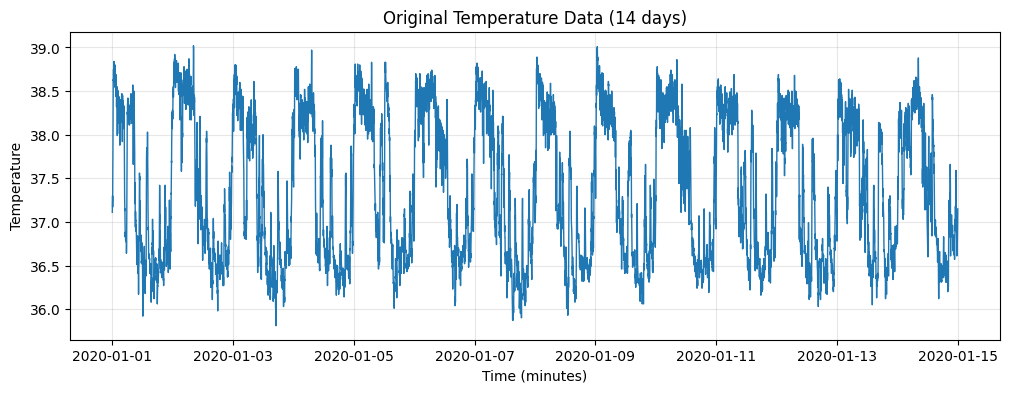

In [33]:
# Quick check to ensure we have the correct data
# basic info about the data
print(f"Data shape: {sample_mouse_f.shape}")
print(f"Min value: {np.min(sample_mouse_f):.2f}, Max value: {np.max(sample_mouse_f):.2f}")

# Plot the original time series
plt.figure(figsize=(12, 4))
plt.plot(sample_mouse_f, linewidth=1)
plt.title('Original Temperature Data (14 days)')
plt.xlabel('Time (minutes)')
plt.ylabel('Temperature')
plt.grid(alpha=0.3)
plt.show()

In [34]:
def perform_cwt(data, wavelet='cmor1.5-1.0', scales=None, sampling_interval_minutes=1):
    """
    Performs Continuous Wavelet Transform on the given data.

    Args:
        data (pd.Series): Input data.
        wavelet (str): Wavelet function (default: 'cmor1.5-1.0').
        scales (array-like): Scales to use. If None, auto-generate based on periods.
        sampling_interval_minutes (int): Sampling interval in minutes.

    Returns:
        tuple: CWT coefficients and corresponding frequencies.
    """
    sampling_period_hours = sampling_interval_minutes / 60.0  # Convert to hours
    
    if scales is None:
        # Determine the range of periods (hours) to analyze
        min_period = 0.5  # Minimum period (hours)
        max_period = len(data) * sampling_period_hours  # Maximum period (total duration)
        
        # Generate frequencies using rfftfreq and convert to periods
        frequencies = np.fft.rfftfreq(len(data), d=sampling_period_hours)
        periods = 1.0 / frequencies[1:]  # Exclude infinite period at freq=0
        
        # Filter periods within the desired range
        valid_periods = periods[(periods >= min_period) & (periods <= max_period)]
        
        # Calculate scales based on periods (scale = Fc * T / sampling_period)
        # For 'cmor1.5-1.0', central frequency Fc=1.0
        scales = 1.0 * valid_periods / sampling_period_hours
    
    # Perform CWT with computed scales
    coefficients, frequencies = pywt.cwt(data.values, scales, wavelet,sampling_period=sampling_period_hours)

    
    return coefficients, frequencies

# Example usage


In [35]:
coef, freq = perform_cwt(sample_mouse_f) #

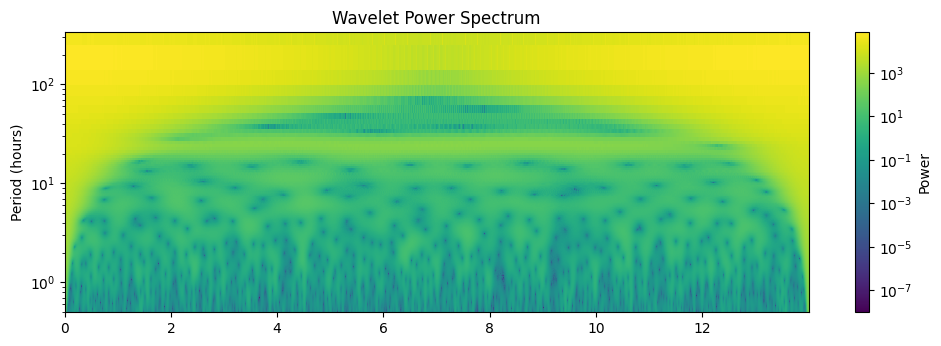

In [36]:
power = (np.abs(coef)) ** 2

periods = 1.0 / freq  # Convert frequencies to periods

def plot_cwt(time, data, power, periods, sampling_interval_minutes=1):
    plt.figure(figsize=(12, 8))
    
    # Time axis (convert to hours/days)
    time_hours = time * sampling_interval_minutes / 60  # Time in hours
    time_days = time_hours / 24  # Time in days

    plt.subplot(2, 1, 1)
    plt.pcolormesh(time_days, periods, power, 
                   shading='auto', 
                   cmap='viridis', 
                   norm='log')  # Logarithmic color scale
    
    plt.colorbar(label='Power')
    plt.yscale('log')  # Logarithmic period axis
    plt.ylim(periods.min(), periods.max())
    plt.ylabel('Period (hours)')
    plt.title('Wavelet Power Spectrum')

# Usage
time = np.arange(len(sample_mouse_f))  # Sample indices
plot_cwt(time, sample_mouse_f.values, power, periods)

In [ ]:
# remove the first and last day to account for edge effects
clipped_data_f = sample_mouse_f[1440:-1440]
clipped_data_m = sample_mouse_m[1440:-1440]

#  Wavelet power spectrum for clipped data

coef, freq = perform_cwt(clipped_data_f)
power_f = (np.abs(coef)) ** 2
periods_f = 1.0 / freq  # frequencies to periods

time = np.arange(len(clipped_data_f))  # Sample indices
plot_cwt(time, clipped_data_f.values, power_f, periods_f)

In [ ]:
# population level analysis
num_mice_f = len(mouse_columns_f)
num_mice_m = len(mouse_columns_m)
n_points = len(temperature_female)

# remove edges
minutes_per_day = 60 * 24
start_idx = minutes_per_day
end_idx = n_points - minutes_per_day

# periods of interest in hours
min_period_hours = 0.5  # 30 minutes
max_period_hours = 200  # 200 hours (to capture multi-day patterns)
num_periods = 100

In [ ]:
# Create periods array (log scale)
periods_hours = np.logspace(np.log10(min_period_hours), np.log10(max_period_hours), num_periods)

# Convert periods to frequencies for wavelet transform
frequencies = 1 / (periods_hours * 60)  # Assuming 1-minute sampling

# Create empty array to store combined coefficients
combined_coeffs_f = None

# Process each mouse
for i, column in enumerate(mouse_columns_f):
    print(f"Processing mouse {i+1}/{num_mice_f}: {column}")    
    mouse_data = temperature_female[column].values
    mouse_data_norm = (mouse_data - np.mean(mouse_data)) / np.std(mouse_data) # Normalize data
    clean_data = mouse_data_norm[start_idx:end_idx] # Remove edge days
    
    coeffs, freqs = pywt.cwt(clean_data, 1/frequencies, 'cmor1.5-1.0') # CWT
    
    # Initialize or add to combined coefficients
    if combined_coeffs_f is None:
        combined_coeffs_f = coeffs
    else:
        combined_coeffs_f += coeffs

# Calculate power (magnitude squared)
combined_power_f = np.abs(combined_coeffs_f) ** 2

In [ ]:
# Create time array
time_f = np.arange(len(clean_data))

# Time axis (convert to days)
time_days_f = time_f / (60 * 24)  # Time in days

# Create the figure for plotting
plt.figure(figsize=(12, 8))

# --- Time-Frequency Plot ---
plt.subplot(2, 1, 1)

plt.pcolormesh(time_days_f, periods_hours, combined_power_f,
               shading='auto',
               cmap='inferno',
               norm='log')  # Logarithmic color scale

plt.colorbar(label='Power')
plt.yscale('log')  # Apply log scale first
hour_ticks = [2, 6, 24]  # Custom hour markers
plt.yticks(hour_ticks, [f'{h}' for h in hour_ticks])  # Then set the ticks
plt.ylabel('Period (hours)')
plt.axhline(y=24, color='red', linestyle='--', alpha=0.7, linewidth=1.2)
plt.title('Combined Wavelet Power Spectrum for all female Mice')


# Add day markers
days = np.arange(int(time_days_f.max()) + 1)
plt.xticks(days, [f'Day {d+1}' for d in days])
plt.grid(axis='x', alpha=0.3)

# --- Global Wavelet Spectrum ---
plt.subplot(2, 1, 2)
global_power = combined_power_f.mean(axis=1)
plt.plot(periods_hours, global_power, 'k-', linewidth=1.5)
plt.xscale('log')
plt.xlabel('Period (hours)')
plt.ylabel('Global Power')
plt.title('Global Wavelet Spectrum (All Mice Combined)')

# Add vertical line at 24h
plt.axvline(x=24, color='r', linestyle='--', alpha=0.7, label='24h (Circadian)')
plt.legend()

plt.tight_layout()
# plt.savefig('combined_wavelet_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Find the power at 24h period (circadian)
idx_24h = np.argmin(np.abs(periods_hours - 24))
power_24h = global_power[idx_24h]
print(f"Power at 24-hour period: {power_24h:.2f}")

# Find the highest power period
max_idx = np.argmax(global_power)
max_period = periods_hours[max_idx]
print(f"Period with maximum power: {max_period:.2f} hours")


Power at 24-hour period: 54563.54
Period with maximum power: 24.05 hours

In [ ]:
# repeat for male mice
# combined coefficients male mice
combined_coeffs_m = None

for i, column in enumerate(mouse_columns_m):
    print(f"Processing mouse {i+1}/{num_mice_m}: {column}")
    mouse_data = temperature_male[column].values
    mouse_data_norm = (mouse_data - np.mean(mouse_data)) / np.std(mouse_data) # Normalize data
    clean_data_m = mouse_data_norm[start_idx:end_idx] # Remove edge days
    coeffs_m, freqs_m = pywt.cwt(clean_data_m, 1/frequencies, 'cmor1.5-1.0')
    if combined_coeffs_m is None:
        combined_coeffs_m = coeffs_m
    else:
        combined_coeffs_m += coeffs_m

# Calculate power (magnitude squared)
combined_power_m = np.abs(combined_coeffs_m) ** 2

In [ ]:
# Create time array
time = np.arange(len(clean_data_m))

# Time axis (convert to days)
time_days = time / (60 * 24)  # Time in days

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.pcolormesh(time_days, periods_hours, combined_power_m, 
               shading='auto', 
               cmap='plasma', 
               norm='log')  # Logarithmic color scale

plt.colorbar(label='Power')
plt.yscale('log')  # Logarithmic period axis
plt.ylim(periods_hours.min(), periods_hours.max())
plt.axhline(y=24, color='red', linestyle='--', alpha=0.7, linewidth=1.2)
plt.ylabel('Period (hours)')
plt.title('Combined Wavelet Power Spectrum (Male Mice)')

# Add day markers
days = np.arange(int(time_days.max()) + 1)
plt.xticks(days, [f'Day {d+1}' for d in days])
plt.grid(axis='x', alpha=0.3)

# --- Global Wavelet Spectrum ---
plt.subplot(2, 1, 2)
global_power_m = combined_power_m.mean(axis=1)
plt.plot(periods_hours, global_power_m, 'k-', linewidth=1.5)
plt.xscale('log')
plt.xlabel('Period (hours)')

plt.ylabel('Global Power')
plt.title('Global Wavelet Spectrum (Male Mice Combined)')

# Add vertical line at 24h
plt.axvline(x=24, color='r', linestyle='--', alpha=0.7, label='24h (Circadian)')
plt.legend()

plt.tight_layout()
plt.savefig('combined_wavelet_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Find the power at 24h period (circadian)
idx_24h = np.argmin(np.abs(periods_hours - 24))
power_24h = global_power_m[idx_24h]
print(f"Power at 24-hour period: {power_24h:.2f}")

# Find the highest power period
max_idx = np.argmax(global_power_m)
max_period = periods_hours[max_idx]
print(f"Period with maximum power: {max_period:.2f} hours")

